### Grabcut
 - graph cut 기반 영역 분할 알고리즘
 - 영상의 픽셀을 그래프의 정점으로 간주하고 픽셀들을 2개의 그룹으로 나누는 최적의 컷을 찾는 방식 
 - 사각형 지정 자동 분할, 사용자가 지정한 전경/배경 정보를 활용
 
``` cv2.grabCut(img, mask,rect, bgdModel, fgdModel ,iterCount, mode=None) -> mask, bgdModel, fgdModel```
 - img : 입력영상 8비트 3채널
 - mask : 입출력 마스크 (cv2.GC_BGD(0),cv2.GC_FGD(1), cv2.PR_BGD(2), cv2.PR_FGD(3) 
 - rect : 

In [1]:
import sys
import numpy as np
import cv2


# 입력 영상 불러오기
src = cv2.imread('.\\ch08\\nemo.jpg')

if src is None:
    print('Image load failed!')
    sys.exit()

# 사각형 지정을 통한 초기 분할
rc = cv2.selectROI(src)
mask = np.zeros(src.shape[:2], np.uint8)

cv2.grabCut(src, mask, rc, None, None, 5, cv2.GC_INIT_WITH_RECT)

# 0: cv2.GC_BGD, 2: cv2.GC_PR_BGD
mask2 = np.where((mask == 0) | (mask == 2), 0, 1).astype('uint8')
dst = src * mask2[:, :, np.newaxis]

# 초기 분할 결과 출력
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()


In [ ]:
import sys
import numpy as np
import cv2


# 입력 영상 불러오기
src = cv2.imread('.\\ch08\\messi5.jpg')

if src is None:
    print('Image load failed!')
    sys.exit()

# 사각형 지정을 통한 초기 분할
mask = np.zeros(src.shape[:2], np.uint8)  # 마스크
bgdModel = np.zeros((1, 65), np.float64)  # 배경 모델
fgdModel = np.zeros((1, 65), np.float64)  # 전경 모델

rc = cv2.selectROI(src)

cv2.grabCut(src, mask, rc, bgdModel, fgdModel, 1, cv2.GC_INIT_WITH_RECT)

# 0: cv2.GC_BGD, 2: cv2.GC_PR_BGD
mask2 = np.where((mask == 0) | (mask == 2), 0, 1).astype('uint8')
dst = src * mask2[:, :, np.newaxis]

# 초기 분할 결과 출력
cv2.imshow('dst', dst)

# 마우스 이벤트 처리 함수 등록
def on_mouse(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(dst, (x, y), 3, (255, 0, 0), -1)
        cv2.circle(mask, (x, y), 3, cv2.GC_FGD, -1)
        cv2.imshow('dst', dst)
    elif event == cv2.EVENT_RBUTTONDOWN:
        cv2.circle(dst, (x, y), 3, (0, 0, 255), -1)
        cv2.circle(mask, (x, y), 3, cv2.GC_BGD, -1)
        cv2.imshow('dst', dst)
    elif event == cv2.EVENT_MOUSEMOVE:
        if flags & cv2.EVENT_FLAG_LBUTTON:
            cv2.circle(dst, (x, y), 3, (255, 0, 0), -1)
            cv2.circle(mask, (x, y), 3, cv2.GC_FGD, -1)
            cv2.imshow('dst', dst)
        elif flags & cv2.EVENT_FLAG_RBUTTON:
            cv2.circle(dst, (x, y), 3, (0, 0, 255), -1)
            cv2.circle(mask, (x, y), 3, cv2.GC_BGD, -1)
            cv2.imshow('dst', dst)


cv2.setMouseCallback('dst', on_mouse)

while True:
    key = cv2.waitKey()
    if key == 13:  # ENTER
        # 사용자가 지정한 전경/배경 정보를 활용하여 영상 분할
        cv2.grabCut(src, mask, rc, bgdModel, fgdModel, 1, cv2.GC_INIT_WITH_MASK)
        mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
        dst = src * mask2[:, :, np.newaxis]
        cv2.imshow('dst', dst)
    elif key == 27:
        break

cv2.destroyAllWindows()


### Moments
 - 영상의 형태를 표현한는 일련의 실수값 
 - 특정 함수 집합과의 상관관계 형태로 계산
 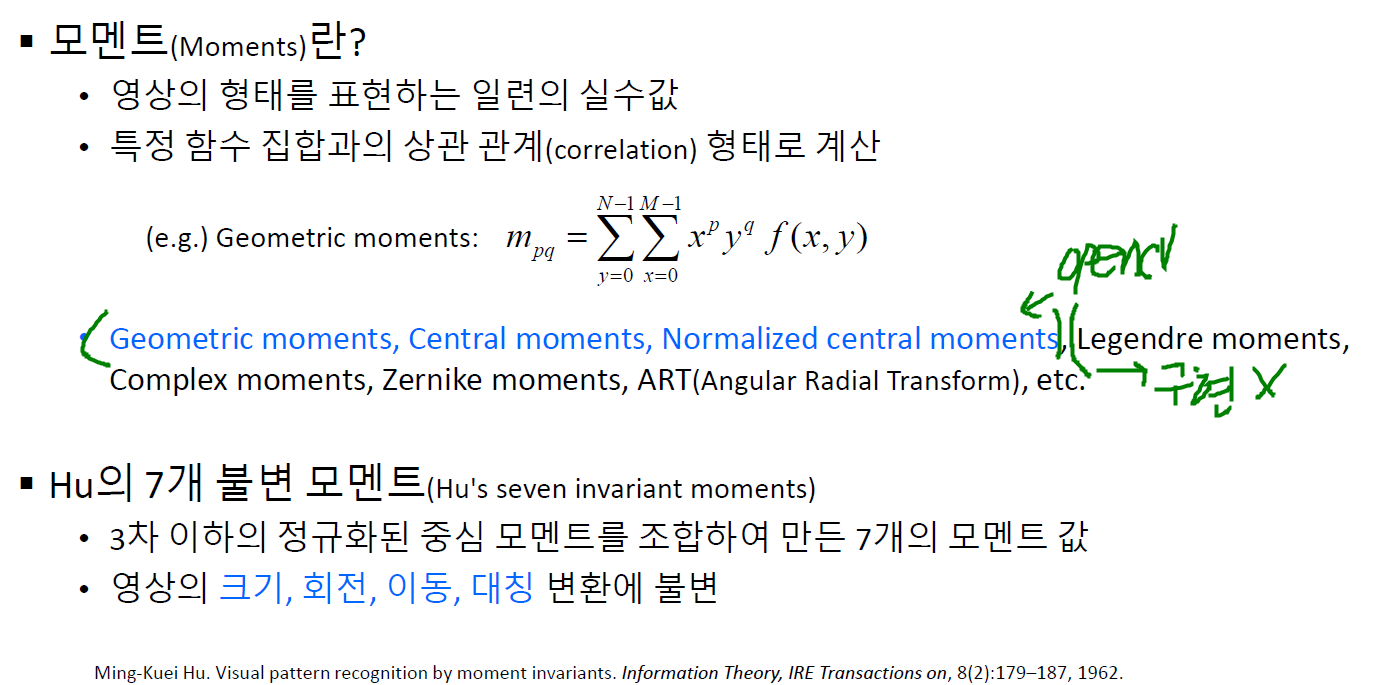

**``` cv2.matchShapes(contour1,contour2, method, parameter)-> retval```**
 - contour1/contour2 : 

In [2]:
import sys
import numpy as np
import cv2


# 영상 불러오기
obj = cv2.imread('.\\ch08\\spades.png', cv2.IMREAD_GRAYSCALE)
src = cv2.imread('.\\ch08\\symbols.png', cv2.IMREAD_GRAYSCALE)

if src is None or obj is None:
    print('Image load failed!')
    sys.exit()

# 객체 영상 외곽선 검출
_, obj_bin = cv2.threshold(obj, 128, 255, cv2.THRESH_BINARY_INV)
obj_contours, _ = cv2.findContours(obj_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
obj_pts = obj_contours[0]

# 입력 영상 분석
_, src_bin = cv2.threshold(src, 128, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(src_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# 결과 영상
dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

# 입력 영상의 모든 객체 영역에 대해서
for pts in contours:
    if cv2.contourArea(pts) < 1000: # 너무 작은 noise제거를 위해
        continue

    rc = cv2.boundingRect(pts)
    cv2.rectangle(dst, rc, (255, 0, 0), 1)

    # 모양 비교
    dist = cv2.matchShapes(obj_pts, pts, cv2.CONTOURS_MATCH_I3, 0)

    cv2.putText(dst, str(round(dist, 4)), (rc[0], rc[1] - 3),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 1, cv2.LINE_AA)

    if dist < 0.1:
        cv2.rectangle(dst, rc, (0, 0, 255), 2)

cv2.imshow('obj', obj)
cv2.imshow('dst', dst)
cv2.waitKey(0)


-1

- 숫자가 작을 수록 가깝다 (거리가 작다) 

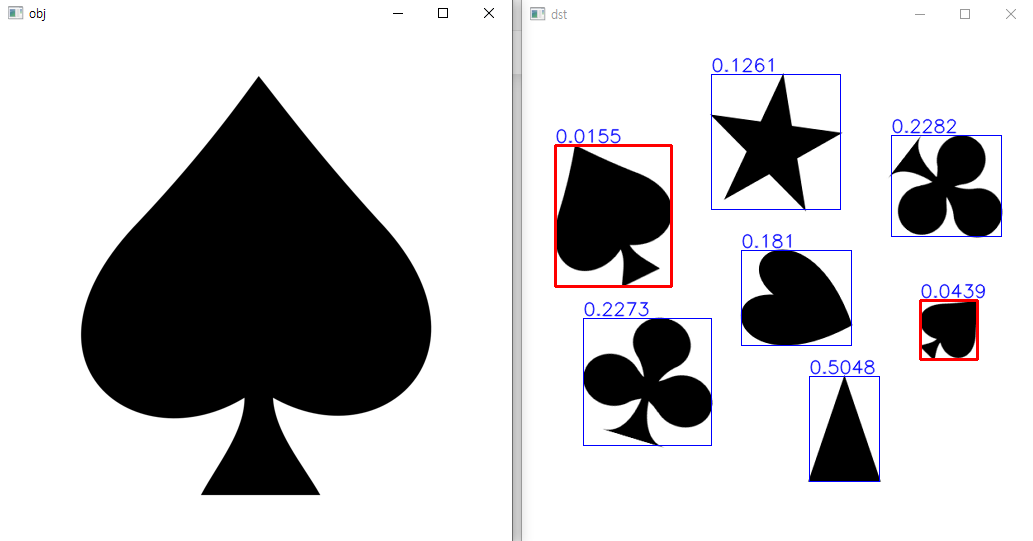

### Template matching 
 - 입력영상에서 템플릿영상(찾을영상)과 일치하는 부분을 찾는 기법
 - 템플릿 영상을 window sliding 하여 하나씩 값을 계산
 
**``` cv2.matchTemplate(image, templ,method, result=None, mask=None)-> result```**
 - image : 입력영상 (W,H)
 - templ : 템플릿영상. image보다 같거나 작은 크기의 같은 타입 (w,h)
 - method: cv2.TM_ flag 지정 
   - |||
     |--|--|
     |TM_SQDIFF/TM_SQDIFF_NORMED| sum of squared difference|
     |TM_CCORR/TM_CCORR_NORMED| (cross) correlation|
     |TM_CCOEFF/TM_CCOEFF/NORMED| correlation coefficient|
     
 - result : 비교결과행렬(np.ndarray, float32,  shape=(W-w+1)X(H-h+1) 

``` T는 template, I 는 src ```

- sqdiff : 같은 위치의 영상을 빼서 제곱
- ccorr : 같은 위치의 곱하고 더해서 계산 (correlation) 
- ccoeff: T를 T' (T의 평균을 빼서 보상) , I를 I'(I의 평균을 빼서 보상) 로 계산 -> 밝기보정이 되므로 더 정확
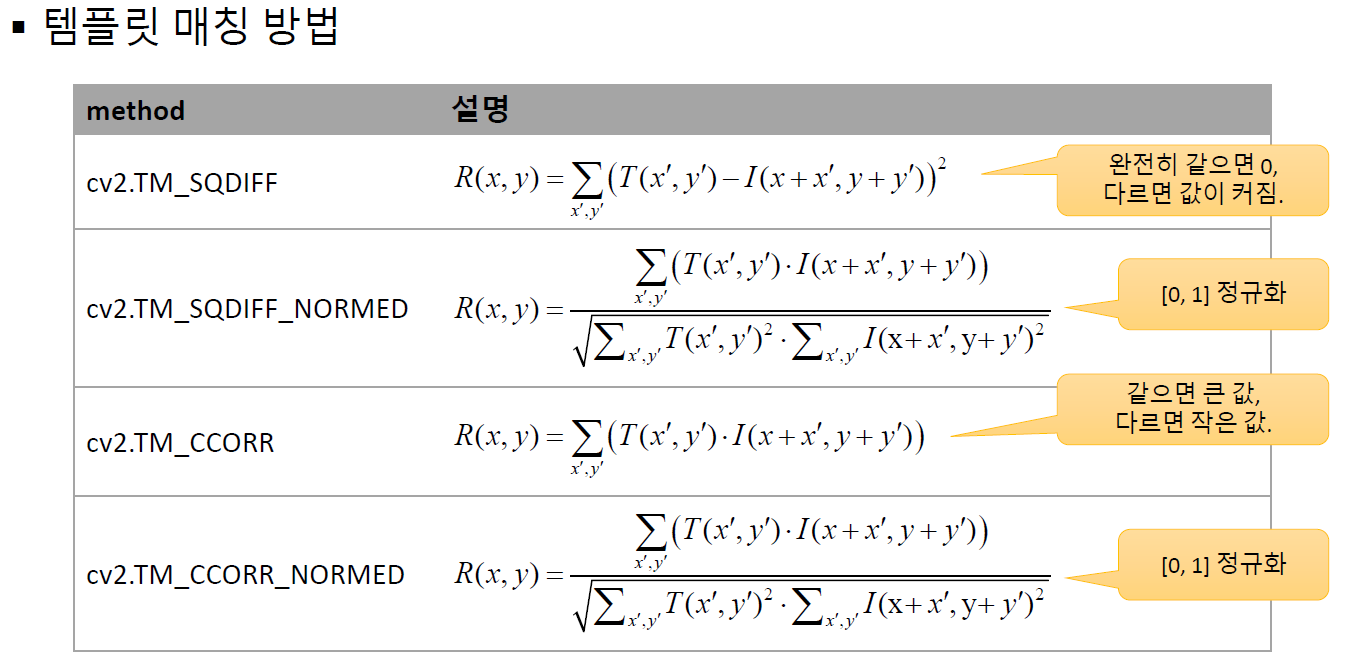
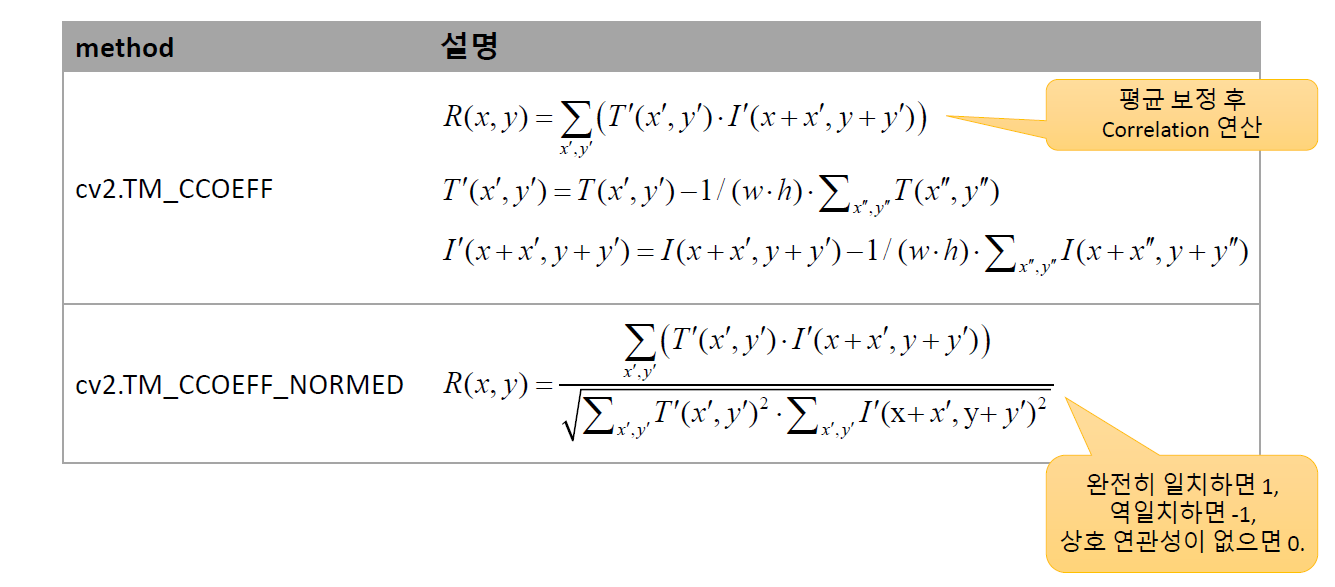    

TM_CCORR에서 메시얼굴을 못찾은 이유는 하얀색이 값이 높아서 correlation값이 높게 나올 수 있다. 
대신 TM_CCORR_NORMED로 쓰면 잘 찾았다

In [7]:
import sys
import numpy as np
import cv2


# 입력 영상 & 템플릿 영상 불러오기
src = cv2.imread('.\\ch08\\circuit.bmp', cv2.IMREAD_GRAYSCALE)
templ = cv2.imread('.\\ch08\\crystal.bmp', cv2.IMREAD_GRAYSCALE)

if src is None or templ is None:
    print('Image load failed!')
    sys.exit()

# 입력 영상 밝기 50증가, 가우시안 잡음(sigma=10) 추가
noise = np.zeros(src.shape, np.int32)
cv2.randn(noise, 50, 10)
src = cv2.add(src, noise, dtype=cv2.CV_8UC3)

# 템플릿 매칭 & 결과 분석
res = cv2.matchTemplate(src, templ, cv2.TM_CCOEFF_NORMED)
res_norm = cv2.normalize(res, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

_, maxv, _, maxloc = cv2.minMaxLoc(res)
# 대상체가 없는경우라도 maxv는 존재하므로 threshold를 지정해줘야한다. 아래 31행처럼
print('maxv:', maxv) 
print('maxloc:', maxloc)

# 매칭 결과를 빨간색 사각형으로 표시
th, tw = templ.shape[:2]
dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)
if maxv > 0.7:
    cv2.rectangle(dst, maxloc, (maxloc[0] + tw, maxloc[1] + th), (0, 0, 255), 2)

# 결과 영상 화면 출력
cv2.imshow('res_norm', res_norm)
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()


maxv: 0.9801327586174011
maxloc: (568, 320)


### Recognition
 - classifying a detected object into different categories
 - 여러 클래스 중 가장 유사한 클래스 선택
 

In [9]:
import sys
import numpy as np
import cv2


def load_digits():
    img_digits = []

    for i in range(10):
        filename = '.\\ch08\\digits\\digit{}.bmp'.format(i)
        img_digits.append(cv2.imread(filename, cv2.IMREAD_GRAYSCALE))

        if img_digits[i] is None:
            return None

    return img_digits


def find_digit(img, img_digits):
    max_idx = -1
    max_ccoeff = -1

    # 최대 NCC 찾기
    for i in range(10):
        img = cv2.resize(img, (100, 150))
        res = cv2.matchTemplate(img, img_digits[i], cv2.TM_CCOEFF_NORMED)

        if res[0, 0] > max_ccoeff:
            max_idx = i
            max_ccoeff = res[0, 0]

    return max_idx


def main():
    # 입력 영상 불러오기
    src = cv2.imread('.\\ch08\\digits_print.bmp')

    if src is None:
        print('Image load failed!')
        return

    # 100x150 숫자 영상 불러오기
    img_digits = load_digits()  # list of ndarray

    if img_digits is None:
        print('Digit image load failed!')
        return

    # 입력 영상 이진화 & 레이블링
    src_gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    _, src_bin = cv2.threshold(src_gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    cnt, _, stats, _ = cv2.connectedComponentsWithStats(src_bin)

    # 숫자 인식 결과 영상 생성
    dst = src.copy()
    for i in range(1, cnt):
        (x, y, w, h, s) = stats[i]

        if s < 1000:
            continue

        # 가장 유사한 숫자 이미지를 선택
        digit = find_digit(src_gray[y:y+h, x:x+w], img_digits)
        cv2.rectangle(dst, (x, y, w, h), (0, 255, 255))
        cv2.putText(dst, str(digit), (x, y - 4), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('dst', dst)
    cv2.waitKey()
    cv2.destroyAllWindows()


if __name__ == '__main__':
    main()


### Cascade classifier (얼굴 검출)
 - Viola-Jones 얼굴 검출기 
   - Positive(얼굴영상), negative(얼굴X) 훈련하여 빠르고 정확하게 얼굴 영역 검출
     (최근 딥러닝기반을 제외하고 그 이전까지 사람의 얼굴을 찾아 초점을 잡아주는 카메라의 기능은 이사람의 논문을 구현한 것)
   
 - (유사하르는 얼굴을 검출하기에 최적화된 필터들, (ex). 눈이 어둡고 눈밑이 밝다)로 얼굴 추출 
   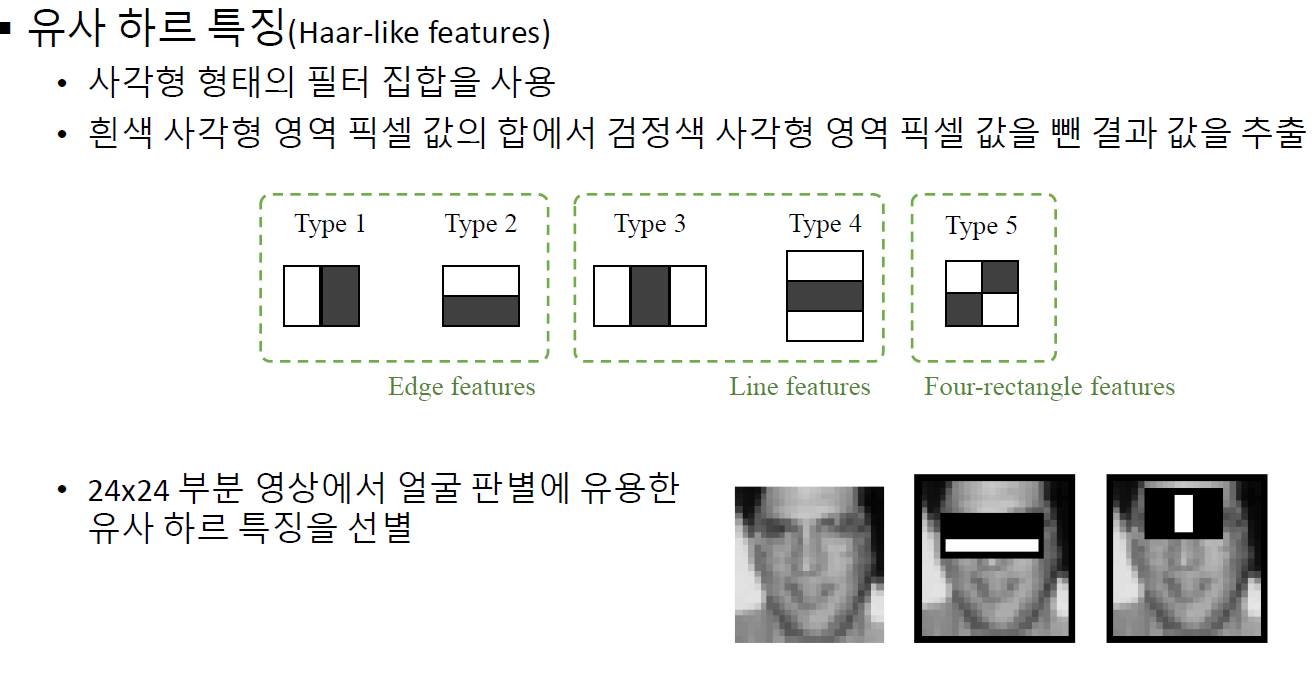
 - 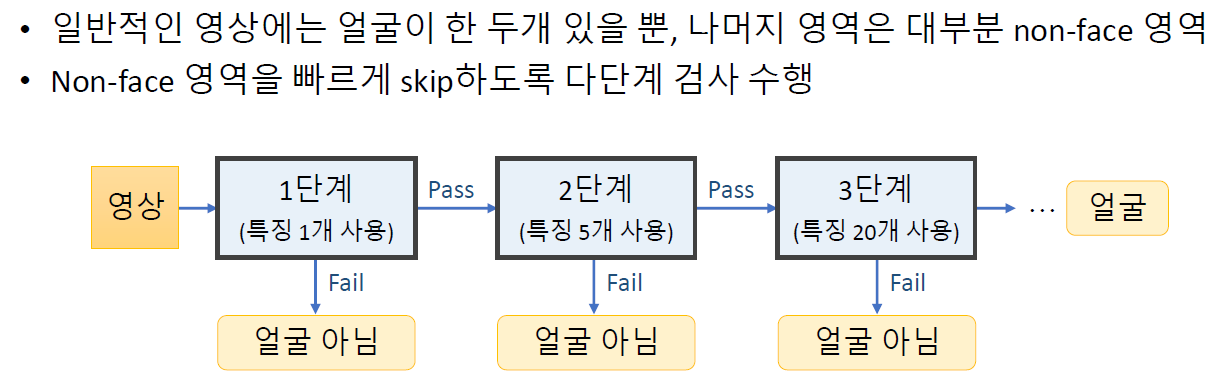

[영상] 케스케이드 분류기 동작 시각화

https://youtu.be/hPCTwxF0qf4
 - 얼굴이라고 판단되는 곳에서는 천천히 지나가고(3단계) 배경에서는 빨리 지나간다(1,2단계)

**``` cv2.CascadeClassifier.load(filename) -> retval```**
 - filename : xml파일이름
   - https://github.com/opencv/opencv/tree/master/data/haarcascades
   - 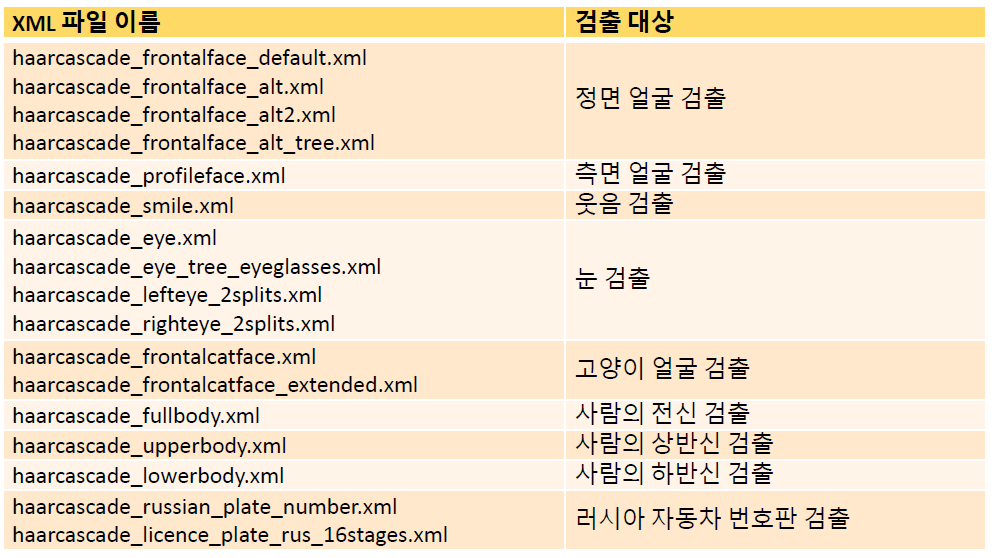
 - retval : True/False
 
**``` cv2.CascadeClassifier.detectMultiScale(image, scaleFactor=None, minNeighbors=None, flags=None,minSize=None,maxSize=None) -> result```**
 - image: 입력영상
 - scaleFactor : 영상 축소 비율로 기본값 1.1 임 
 - minNeighbors: 얼마나 많은 이웃 사각형이 검출되야 최종 검출로 설정할 것인지. 기본값 3
 - flags : 사용 X
 - min/max size: 최소/최대 객체 크기
 - result: 검출된 객체의 사각형 정보(x,y,w,h) np.ndarray. np.int32. shape=(N,4) 

In [16]:
import sys
import numpy as np
import cv2


src = cv2.imread('.\\ch08\\lenna.bmp')

if src is None:
    print('Image load failed!')
    sys.exit()

classifier = cv2.CascadeClassifier('.\\ch08\\haarcascade_frontalface_alt2.xml')

if classifier.empty():
    print('XML load failed!')
    sys.exit()
tm=cv2.TickMeter()
tm.start()

faces = classifier.detectMultiScale(src,scaleFactor=1.2 , minSize=(100,100))

for (x, y, w, h) in faces:
    cv2.rectangle(src, (x, y, w, h), (255, 0, 255), 2)

tm.stop()
print(tm.getTimeMilli())
cv2.imshow('src', src)
cv2.waitKey()
cv2.destroyAllWindows()


7.0401


In [17]:
import sys
import numpy as np
import cv2


src = cv2.imread('.\\ch08\\lenna.bmp')

if src is None:
    print('Image load failed!')
    sys.exit()

face_classifier = cv2.CascadeClassifier('.\\ch08\\haarcascade_frontalface_alt2.xml')
eye_classifier = cv2.CascadeClassifier('.\\ch08\\haarcascade_eye.xml')

if face_classifier.empty() or eye_classifier.empty():
    print('XML load failed!')
    sys.exit()

faces = face_classifier.detectMultiScale(src)

for (x1, y1, w1, h1) in faces:
    cv2.rectangle(src, (x1, y1), (x1 + w1, y1 + h1), (255, 0, 255), 2)

    faceROI = src[y1:y1 + h1 // 2, x1:x1 + w1]
    eyes = eye_classifier.detectMultiScale(faceROI)

    for (x2, y2, w2, h2) in eyes:
        center = (x2 + w2 // 2, y2 + h2 // 2)
        cv2.circle(faceROI, center, w2 // 2, (255, 0, 0), 2, cv2.LINE_AA)

cv2.imshow('src', src)
cv2.waitKey()
cv2.destroyAllWindows()


### HOG 보행자 검출
 - Histogram of Oriented Gradients 
 


In [26]:
import sys
import random
import numpy as np
import cv2


# 동영상 불러오기
cap = cv2.VideoCapture('.\\ch08\\vtest.avi')

if not cap.isOpened():
    print('Video open failed!')
    sys.exit()

# 보행자 검출을 위한 HOG 기술자 설정
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

while True:
    ret, frame = cap.read()

    if not ret:
        break

    # 매 프레임마다 보행자 검출
    detected, _ = hog.detectMultiScale(frame)

    # 검출 결과 화면 표시
    for (x, y, w, h) in detected:
        c = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        cv2.rectangle(frame, (x, y, w, h), c, 3)

    cv2.imshow('frame', frame)
    if cv2.waitKey(1) == 27:
        break

cv2.destroyAllWindows()


[실전코딩] 간단 스노우 앱

In [27]:
import sys
import numpy as np
import cv2


# 3채널 img 영상에 4채널 item 영상을 pos 위치에 합성
def overlay(img, glasses, pos):
    # 실제 합성을 수행할 부분 영상 좌표 계산
    sx = pos[0]
    ex = pos[0] + glasses.shape[1]
    sy = pos[1]
    ey = pos[1] + glasses.shape[0]

    # 합성할 영역이 입력 영상 크기를 벗어나면 무시
    if sx < 0 or sy < 0 or ex > img.shape[1] or ey > img.shape[0]:
        return

    # 부분 영상 참조. img1: 입력 영상의 부분 영상, img2: 안경 영상의 부분 영상
    img1 = img[sy:ey, sx:ex]   # shape=(h, w, 3)
    img2 = glasses[:, :, 0:3]  # shape=(h, w, 3)
    alpha = 1. - (glasses[:, :, 3] / 255.)  # shape=(h, w)

    # BGR 채널별로 두 부분 영상의 가중합
    img1[..., 0] = (img1[..., 0] * alpha + img2[..., 0] * (1. - alpha)).astype(np.uint8)
    img1[..., 1] = (img1[..., 1] * alpha + img2[..., 1] * (1. - alpha)).astype(np.uint8)
    img1[..., 2] = (img1[..., 2] * alpha + img2[..., 2] * (1. - alpha)).astype(np.uint8)


# 카메라 열기
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print('Camera open failed!')
    sys.exit()

w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('output.avi', fourcc, 30, (w, h))

# Haar-like XML 파일 열기
face_classifier = cv2.CascadeClassifier('.\\ch08\\haarcascade_frontalface_alt2.xml')
eye_classifier = cv2.CascadeClassifier('.\\ch08\\haarcascade_eye.xml')

if face_classifier.empty() or eye_classifier.empty():
    print('XML load failed!')
    sys.exit()

# 안경 PNG 파일 열기 (Image from http://www.pngall.com/)
glasses = cv2.imread('.\\ch08\\glasses.png', cv2.IMREAD_UNCHANGED)

if glasses is None:
    print('PNG image open failed!')
    sys.exit()

ew, eh = glasses.shape[:2]  # 가로, 세로 크기
ex1, ey1 = 240, 300  # 왼쪽 눈 좌표
ex2, ey2 = 660, 300  # 오른쪽 눈 좌표

# 매 프레임에 대해 얼굴 검출 및 안경 합성
while True:
    ret, frame = cap.read()

    if not ret:
        break

    # 얼굴 검출
    faces = face_classifier.detectMultiScale(frame, scaleFactor=1.2,
                                             minSize=(100, 100), maxSize=(400, 400))

    for (x, y, w, h) in faces:
        #cv2.rectangle(frame, (x, y, w, h), (255, 0, 255), 2)

        # 눈 검출
        faceROI = frame[y:y + h // 2, x:x + w]
        eyes = eye_classifier.detectMultiScale(faceROI)

        # 눈을 2개 검출한 것이 아니라면 무시
        if len(eyes) != 2:
            continue

        # 두 개의 눈 중앙 위치를 (x1, y1), (x2, y2) 좌표로 저장
        x1 = x + eyes[0][0] + (eyes[0][2] // 2)
        y1 = y + eyes[0][1] + (eyes[0][3] // 2)
        x2 = x + eyes[1][0] + (eyes[1][2] // 2)
        y2 = y + eyes[1][1] + (eyes[1][3] // 2)

        if x1 > x2:
            x1, y1, x2, y2 = x2, y2, x1, y1

        #cv2.circle(faceROI, (x1, y1), 5, (255, 0, 0), 2, cv2.LINE_AA)
        #cv2.circle(faceROI, (x2, y2), 5, (255, 0, 0), 2, cv2.LINE_AA)

        # 두 눈 사이의 거리를 이용하여 스케일링 팩터를 계산 (두 눈이 수평하다고 가정)
        fx = (x2 - x1) / (ex2 - ex1)
        glasses2 = cv2.resize(glasses, (0, 0), fx=fx, fy=fx, interpolation=cv2.INTER_AREA)

        # 크기 조절된 안경 영상을 합성할 위치 계산 (좌상단 좌표)
        pos = (x1 - int(ex1 * fx), y1 - int(ey1 * fx))

        # 영상 합성
        overlay(frame, glasses2, pos)

    # 프레임 저장 및 화면 출력
    out.write(frame)
    cv2.imshow('frame', frame)

    if cv2.waitKey(1) == 27:
        break

cap.release()
out.release()
cv2.destroyAllWindows()
